In [1]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [2]:
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

In [3]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
from torch.utils.data import TensorDataset, random_split, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
from utils import pgd_attack
import ecg_plot
from utils import plot_ecgs
%matplotlib inline

In [4]:
def _padding(downsample, kernel_size):
    """Compute required padding"""
    padding = max(0, int(np.floor((kernel_size - downsample + 1) / 2)))
    return padding


def _downsample(n_samples_in, n_samples_out):
    """Compute downsample rate"""
    downsample = int(n_samples_in // n_samples_out)
    if downsample < 1:
        raise ValueError("Number of samples should always decrease")
    if n_samples_in % n_samples_out != 0:
        raise ValueError("Number of samples for two consecutive blocks "
                         "should always decrease by an integer factor.")
    return downsample


class ResBlock1d(nn.Module):
    """Residual network unit for unidimensional signals."""

    def __init__(self, n_filters_in, n_filters_out, downsample, kernel_size, dropout_rate):
        if kernel_size % 2 == 0:
            raise ValueError("The current implementation only support odd values for `kernel_size`.")
        super(ResBlock1d, self).__init__()
        # Forward path
        padding = _padding(1, kernel_size)
        self.conv1 = nn.Conv1d(n_filters_in, n_filters_out, kernel_size, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(n_filters_out)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        padding = _padding(downsample, kernel_size)
        self.conv2 = nn.Conv1d(n_filters_out, n_filters_out, kernel_size,
                               stride=downsample, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(n_filters_out)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Skip connection
        skip_connection_layers = []
        # Deal with downsampling
        if downsample > 1:
            maxpool = nn.MaxPool1d(downsample, stride=downsample)
            skip_connection_layers += [maxpool]
        # Deal with n_filters dimension increase
        if n_filters_in != n_filters_out:
            conv1x1 = nn.Conv1d(n_filters_in, n_filters_out, 1, bias=False)
            skip_connection_layers += [conv1x1]
        # Build skip conection layer
        if skip_connection_layers:
            self.skip_connection = nn.Sequential(*skip_connection_layers)
        else:
            self.skip_connection = None

    def forward(self, x, y):
        """Residual unit."""
        if self.skip_connection is not None:
            y = self.skip_connection(y)
        else:
            y = y
        # 1st layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # 2nd layer
        x = self.conv2(x)
        x += y  # Sum skip connection and main connection
        y = x
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        return x, y


class ResNet1d(nn.Module):
    """Residual network for unidimensional signals.
    Parameters
    ----------
    input_dim : tuple
        Input dimensions. Tuple containing dimensions for the neural network
        input tensor. Should be like: ``(n_filters, n_samples)``.
    blocks_dim : list of tuples
        Dimensions of residual blocks.  The i-th tuple should contain the dimensions
        of the output (i-1)-th residual block and the input to the i-th residual
        block. Each tuple shoud be like: ``(n_filters, n_samples)``. `n_samples`
        for two consecutive samples should always decrease by an integer factor.
    dropout_rate: float [0, 1), optional
        Dropout rate used in all Dropout layers. Default is 0.8
    kernel_size: int, optional
        Kernel size for convolutional layers. The current implementation
        only supports odd kernel sizes. Default is 17.
    References
    ----------
    .. [1] K. He, X. Zhang, S. Ren, and J. Sun, "Identity Mappings in Deep Residual Networks,"
           arXiv:1603.05027, Mar. 2016. https://arxiv.org/pdf/1603.05027.pdf.
    .. [2] K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition," in 2016 IEEE Conference
           on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778. https://arxiv.org/pdf/1512.03385.pdf
    """

    def __init__(self, input_dim, blocks_dim, n_classes, kernel_size=17, dropout_rate=0.8):
        super(ResNet1d, self).__init__()
        # First layers
        n_filters_in, n_filters_out = input_dim[0], blocks_dim[0][0]
        n_samples_in, n_samples_out = input_dim[1], blocks_dim[0][1]
        downsample = _downsample(n_samples_in, n_samples_out)
        padding = _padding(downsample, kernel_size)
        self.conv1 = nn.Conv1d(n_filters_in, n_filters_out, kernel_size, bias=False,
                               stride=downsample, padding=padding)
        self.bn1 = nn.BatchNorm1d(n_filters_out)

        # Residual block layers
        self.res_blocks = []
        for i, (n_filters, n_samples) in enumerate(blocks_dim):
            n_filters_in, n_filters_out = n_filters_out, n_filters
            n_samples_in, n_samples_out = n_samples_out, n_samples
            downsample = _downsample(n_samples_in, n_samples_out)
            resblk1d = ResBlock1d(n_filters_in, n_filters_out, downsample, kernel_size, dropout_rate)
            self.add_module('resblock1d_{0}'.format(i), resblk1d)
            self.res_blocks += [resblk1d]

        # Linear layer
        n_filters_last, n_samples_last = blocks_dim[-1]
        last_layer_dim = n_filters_last * n_samples_last
        self.lin = nn.Linear(last_layer_dim, n_classes)
        self.n_blk = len(blocks_dim)

    def forward(self, x):
        """Implement ResNet1d forward propagation"""
        x = x.transpose(2,1)
        # First layers
        x = self.conv1(x)
        x = self.bn1(x)

        # Residual blocks
        y = x
        for blk in self.res_blocks:
            x, y = blk(x, y)

        # Flatten array
        x = x.view(x.size(0), -1)

        # Fully conected layer
        x = self.lin(x)
        return x

In [5]:
def eval_loop(epoch, dataloader, model, loss_function, device, adversarial=False, adv_eps=4e-2, adv_alpha=1e-2, adv_steps=10):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_pred, valid_true = [], []
    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)
        
        if adversarial:
            # generate adversarial samples
            traces = pgd_attack(model, traces, diagnoses, device, eps=adv_eps, alpha=adv_alpha, steps=adv_steps)

        with torch.no_grad():
            # forward pass
            output = model(traces)
            loss = loss_function(output, diagnoses)
            
            # save predictions
            valid_pred.append(output.detach().cpu().numpy())
            valid_true.append(diagnoses.detach().cpu().numpy())

            # Update accumulated values
            total_loss += loss.detach().cpu().numpy()
            n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_pred), np.vstack(valid_true)

In [6]:
# hyperparameters
learning_rate = 1e-3
weight_decay = 1e-2  
num_epochs = 20
batch_size = 64
train_cut = 0.8

In [7]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = np.array(df['AF'])

# one-hot encode labels
# labels = pd.get_dummies(labels)

labels = torch.tensor(labels, dtype=torch.float32).reshape(-1,1)

# load dataset
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))

# split data
len_train = int(train_cut * len_dataset)
len_valid = len_dataset - len_train
dataset_train, dataset_valid = random_split(dataset, [len_train, len_valid])

# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)                         
tqdm.write("Done!\n")

Use device: cuda

Done!



In [13]:
eps_list = [0, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]
loss_function = nn.BCEWithLogitsLoss()

# Create dictionary for storing metrics for each model
metrics = {}

for model_path in ['model_20.pth', "model_adv_20_after_9_eps4e-2.pth"]:
    # Define the model
    model = ResNet1d(input_dim=(8, 4096),n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['model'])
    model.to(device)
    
    metrics[model_path] = {}
    
    for eps in eps_list:
        # Evaluate with adversarial examples
        adv_valid_loss, adv_y_pred, adv_y_true = eval_loop(0, valid_dataloader, model, loss_function, device, adversarial=True, adv_eps=eps, adv_alpha=eps/5, adv_steps=10)

        adv_auroc = roc_auc_score(adv_y_true, adv_y_pred)
        adv_ap = average_precision_score(adv_y_true, adv_y_pred)

        # apply sigmoid to y_pred
        adv_y_pred = torch.sigmoid(torch.tensor(adv_y_pred)).numpy()
        adv_y_pred = np.round(adv_y_pred)

        # compute accuracy
        adv_accuracy = accuracy_score(adv_y_true, adv_y_pred)
        adv_f1 = f1_score(adv_y_true, adv_y_pred, average='binary')
        
        # store the metrics for this model
        metrics[model_path][eps] = {'accuracy': adv_accuracy, 'auroc': adv_auroc, 'ap': adv_ap, 'f1': adv_f1}


    # # Print table comparing results
    # from tabulate import tabulate

    # table = [["", "Accuracy", "AUROC", "AUPRC", "F1"],
    #             ["No adversarial", accuracy, auroc, ap, f1],
    #             ["Adversarial", adv_accuracy, adv_auroc, adv_ap, adv_f1]]
    # print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

Evaluation Epoch  0:   0%|          | 0/32 [00:00<?, ?it/s]

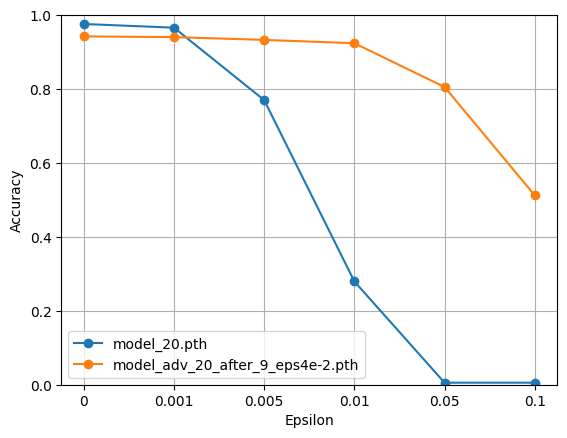

In [ ]:
# plot the accuracy for each model and each epsilon
for model_path in metrics:
    # get the metrics for this model
    model_metrics = metrics[model_path]
    
    # get the accuracy for each epsilon
    acc = [model_metrics[eps]['accuracy'] for eps in model_metrics]
    
    # plot the accuracy
    plt.plot([str(eps) for eps in eps_list], acc, label=model_path, marker='o')
    
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.grid()

plt.ylim(0, 1)
plt.legend()

plt.show()

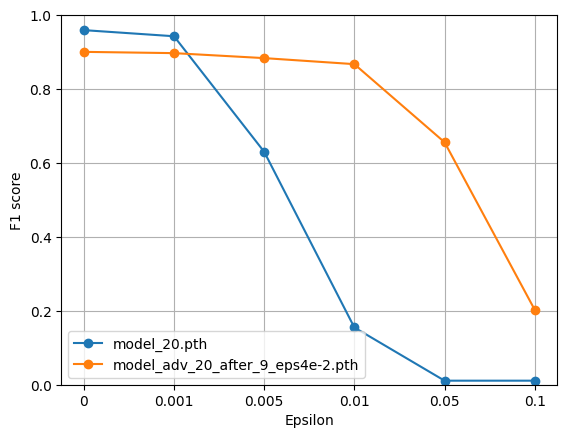

In [ ]:
# plot the f1 score for each model and each epsilon
for model_path in metrics:
    # get the metrics for this model
    model_metrics = metrics[model_path]
    
    # get the accuracy for each epsilon
    f1 = [model_metrics[eps]['f1'] for eps in model_metrics]
    
    # plot the accuracy
    plt.plot([str(eps) for eps in eps_list], f1, label=model_path, marker='o')
    
plt.xlabel('Epsilon')
plt.ylabel('F1 score')
plt.grid()

plt.ylim(0, 1)
plt.legend()

plt.show()

In [8]:
model = ResNet1d(input_dim=(8, 4096),n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8
checkpoint = torch.load('model_20.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model'])
model.to(device)
print("Model loaded!")

Model loaded!


3.0 10.24


<Figure size 640x480 with 0 Axes>

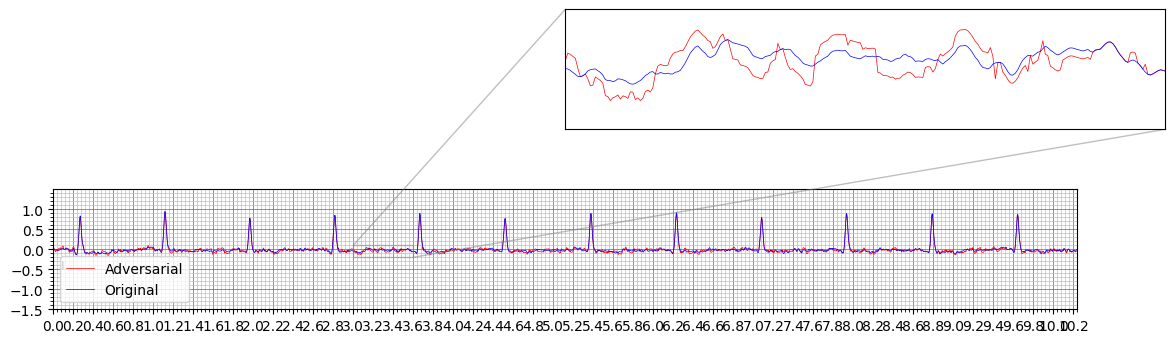

In [42]:
import utils
from importlib import reload
reload(utils)

eps = 5e-2

# Plot some adversarial examples
traces, diagnoses = next(iter(valid_dataloader))

ecg_sample = np.transpose(traces[0])

# Generate adversarial examples
traces = pgd_attack(model, traces, diagnoses, device, eps=eps, alpha=eps/5, steps=10)

ecg_sample_adv = np.transpose(traces[0].cpu().numpy())

# Concatenate the two ecgs to (16, 4096)
#ecg_sample = np.concatenate((ecg_sample, ecg_sample_adv), axis=0)

# Interleave them instead such that the adversarial example is in between the original
#ecg_sample = np.array([val for pair in zip(ecg_sample, ecg_sample_adv) for val in pair])

# Select the first two leads
ecg_sample = ecg_sample[0:1]

ecg_sample_adv = ecg_sample_adv[0:1]

plt.figure()
#lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'I-adv', 'II-adv', 'V1-adv', 'V2-adv', 'V3-adv', 'V4-adv', 'V5-adv', 'V6-adv']
lead = ['I', 'I-adv', 'II', 'II-adv', 'V1', 'V1-adv', 'V2', 'V2-adv', 'V3', 'V3-adv', 'V4', 'V4-adv', 'V5', 'V5-adv', 'V6', 'V6-adv']
#lead = ['I', 'I-adv']
utils.plot_ecgs(ecg_sample, ecg_sample_adv, sample_rate=400, style = 'bw', row_height=6, lead_index=lead, columns=1, title="",show_zoom=True, zoom_box=[3.0, 3.6, -0.2, 0.1], zoom_rate=10)
plt.legend(['Adversarial', 'Original'])
plt.show()
